In [2]:
import numpy as np
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
file = 'ASLdatasetGroup23.hdf5'
with h5py.File(file, 'r') as rd:
    x_train = np.array(rd['x_train'])
    y_train = np.array(rd['y_train'])
    x_test = np.array(rd['x_test'])
    y_test = np.array(rd['y_test'])

XT = np.copy(x_train)
XT = XT.astype('float32')/255

XTE = np.copy(x_test)
XTE = XTE.astype('float32')/255

class_enum = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
print(XT.shape)
print(y_train.shape)
print(XTE.shape)
print(y_test.shape)

class ASLSet(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        'Initialization'
        self.labels = labels
        self.images = images
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'
        img = self.images[index]
        lab = self.labels[index]
        X = torch.from_numpy(img)
        Y = lab
        
        return X, Y

train_set = ASLSet(XT,y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)

test_set = ASLSet(XTE, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 100, shuffle = False)

loss_func = nn.CrossEntropyLoss()


(99300, 3, 125, 125)
(99300,)
(1450, 3, 125, 125)
(1450,)


Using device: cuda:0
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 2.0 GB
Cached:    3.3 GB
Epoch: 01: Train Loss: 0.0111, Train Accuracy: 65.608%
            Test Loss: 0.0030, Test Accuracy: 90.276%
Epoch: 02: Train Loss: 0.0023, Train Accuracy: 92.349%
            Test Loss: 0.0014, Test Accuracy: 95.408%
Epoch: 03: Train Loss: 0.0012, Train Accuracy: 96.214%
            Test Loss: 0.0020, Test Accuracy: 93.954%
Epoch: 04: Train Loss: 0.0007, Train Accuracy: 97.684%
            Test Loss: 0.0010, Test Accuracy: 97.006%
Epoch: 05: Train Loss: 0.0006, Train Accuracy: 98.070%
            Test Loss: 0.0008, Test Accuracy: 97.747%
Epoch: 06: Train Loss: 0.0005, Train Accuracy: 98.476%
            Test Loss: 0.0012, Test Accuracy: 96.546%
Epoch: 07: Train Loss: 0.0005, Train Accuracy: 98.720%
            Test Loss: 0.0006, Test Accuracy: 98.138%
Epoch: 08: Train Loss: 0.0004, Train Accuracy: 98.865%
            Test Loss: 0.0005, Test Accuracy: 98.397%
Epoch: 09: Train Loss:

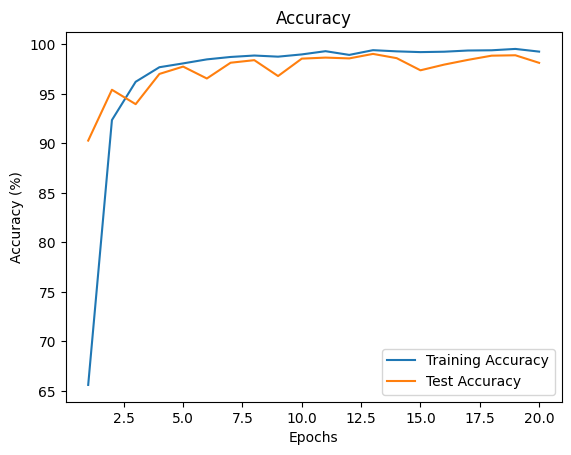

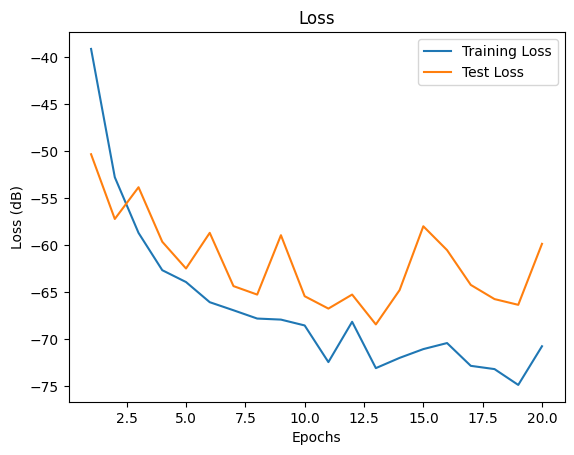

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding = 0)   # 1st convolutional layer 
        self.conv2 = nn.Conv2d(8, 16, 3, padding = 0)  # 2nd convolutional layer
        
        self.fc1 = nn.Linear(13456, 6000)  # 1st fully connected layer
        self.fc2 = nn.Linear(6000, 29)     # 2nd fully connected layer
        
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.dropout = torch.nn.Dropout(p = 0.3)
        self.relu = torch.nn.GELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
       
        return x

model1 = Net()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model1 = model1.to(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

train_loss_arr = []
train_acc_arr = []
test_loss_arr = []
test_acc_arr = []
num_epochs = 20
for epoch in range(num_epochs):
    train_correct = 0
    test_correct = 0
    train_loss = 0
    test_loss = 0
    model1.train()

    for images, labels in train_loader:
        labels = labels.to(device)
        images = images.to(device)

        #Forward Prop
        outputs = model1(images)
        
        loss = loss_func(outputs,labels)
        
        #Back Prop
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        predictions = torch.max(outputs.cpu(),1)[1]
        train_correct += (predictions == labels.cpu()).sum().numpy()
        train_loss += loss.cpu().data

    for images, labels in test_loader:
        images = images.to(device)

        #Forward Prop
        outputs = model1(images).cpu()
        loss = loss_func(outputs, labels)
        predictions = torch.max(outputs, 1)[1]
        test_correct += (predictions == labels).sum().numpy()
        test_loss += loss.cpu().data

    train_loss_arr.append(train_loss/len(train_loader.dataset))
    train_acc_arr.append(train_correct/len(train_loader.dataset))
    test_loss_arr.append(test_loss/len(test_loader.dataset))
    test_acc_arr.append(test_correct/len(test_loader.dataset))

    print(f'Epoch: {epoch+1:02d}: Train Loss: {(train_loss/len(train_loader.dataset)):.4f}, Train Accuracy: {(100*train_correct/len(train_loader.dataset)):2.3f}%')
    print("           ", f'Test Loss: {(test_loss/len(test_loader.dataset)):.4f}, Test Accuracy: {(100*test_correct/len(test_loader.dataset)):2.3f}%')
print(f'Final Train Accuracy: {100*train_acc_arr[-1]:2.3f}, Final Test Accuracy: {100*test_acc_arr[-1]:2.3f}')

a = plt.figure(1)
plt.plot(range(1, num_epochs + 1), 100*np.array(train_acc_arr), label = "Training Accuracy")
plt.plot(range(1, num_epochs + 1), 100*np.array(test_acc_arr), label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy")
plt.legend()
plt.show()

b = plt.figure(2)
plt.plot(range(1, num_epochs + 1), 20*np.log10(np.array(train_loss_arr)), label = "Training Loss")
plt.plot(range(1, num_epochs + 1), 20*np.log10(np.array(test_loss_arr)), label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (dB)")
plt.title("Loss")
plt.legend()
plt.show()
